<a href="https://colab.research.google.com/github/from1pandas-importLove/dbis1/blob/master/%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Nelder-Mead method

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import sympy as sym

sym.init_printing()


In [0]:
x = sym.Symbol('x')
y = sym.Symbol('y')

target_function = (10*(x-y)**2 + (x-1)**2 )**(1/4)
constraint_function = x + y < 1

In [4]:
target_function

In [5]:
constraint_function

In [0]:
f = sym.lambdify([x, y], target_function, 'numpy')
f_constraint = sym.lambdify([x, y], constraint_function, 'numpy')

In [0]:
n = 3
eps = 1e-4 # Accuracy
alpha = 1 # Reflection
beta = 0.5 # Contraction
gamma = 2 # Expansion
delta = 0.5 # Shrink

# Functions for our algorythm

In [0]:
def centroid(b,d):
    return (b+d)/2

In [0]:
def reflection(c, xh, alpha):
    return c + alpha*(c-xh)

In [0]:
def expansion(c, gamma, xr):
    return c + gamma*(xr-c)

In [0]:
def contraction(c, beta, xh):
    return c + beta*(xh-c)

In [0]:
def shrink(xl, delta, xj):
    return xl + delta * (xj-xl)

In [0]:
def order(a,col=2):
    return a[a[:,col].argsort()]

In [0]:
def get_triangle(a):
    x1 = a[0,0]
    y1 = a[0,1]
    
    x2 = a[1,0]
    y2 = a[1,1]
    
    x3 = a[2,0]
    y3 = a[2,1]
    return [(x1,y1),(x2,y2),(x3,y3)]

In [0]:
def get_triangle_coord(triangle,coord):
    return [triangle[0][coord],triangle[1][coord],triangle[2][coord]]

In [0]:
def plot_propagation(triangles,x_range,y_range,f,f_constraint):
    
    x, y = np.meshgrid(np.linspace(x_range[0], x_range[1], (x_range[1]-x_range[0])*100),
                   np.linspace(y_range[0], y_range[1], (y_range[1]-y_range[0])*100))

    fig, ax = plt.subplots(1,figsize=(20, 10))
    C1 = ax.contour(x, y, f(x, y))
    
    C2 = plt.contour(x,y,f_constraint(x,y),[0],colors='red')
    plt.clabel(C2, inline=1, fontsize=10)
    C2.collections[0].set_label('Constraint')
    plt.legend(loc='upper left')
    
    for i in range(len(triangles)):
        x_tri = get_triangle_coord(triangles[i],0)
        y_tri = get_triangle_coord(triangles[i],1)
        triang = mtri.Triangulation(x_tri, y_tri)
        plt.triplot(triang, marker="*")

In [0]:
def Nelder_Mead_opt(f,f_constraint,X_0,n=3,eps=1e-1,alpha=1,beta=0.5,gamma=2,delta=0.5,print_flag=True,plot_flag=False, max_iter=200):
    xx = np.array([X_0[0][0],X_0[1][0],X_0[2][0]])
    yy = np.array([X_0[0][1],X_0[1][1],X_0[2][1]])
    ff = np.array([f(xx[0],yy[0]), f(xx[1],yy[1]), f(xx[2],yy[2])])
                               
    a = np.array([[xx[0],yy[0],ff[0]],[xx[1],yy[1],ff[1]],[xx[2],yy[2],ff[2]]])
    a = order(a)
    flag = True
    n_iter = 0
    triangles = []
    
    while flag:
        n_iter = n_iter +1
        a = order(a)
        print('a = ', a)
        print('\nfun = ', f(a[0][0], a[0][1]))
        tri_i = get_triangle(a)
        triangles.append(tri_i)
        points = triangles[n_iter - 1][0]
        if print_flag:
                print('iteration: {n_iter}\t  [x, y] = {points}\n  f(x, y) = {value}\n\n '.format(points=points, n_iter=n_iter, value=f(points[0],points[1])))
        if f_constraint(a[0][0], a[0][1]) == False:
            a[0][2] = 10 ** 10
        if abs( (a[0][2] - a[1][2] )) < eps:
            flag = False
            break

        xx_0 = centroid(a[0,0],a[1,0])
        yy_0 = centroid(a[0,1],a[1,1])

        xx_r = reflection(xx_0, a[2,0], alpha)
        yy_r = reflection(yy_0, a[2,1], alpha)
        ff_r = f(xx_r,yy_r)
        nr  = np.array([xx_r,yy_r,ff_r])

        a_n = np.vstack([a, nr])
        a_n = order(a_n)
        if ff_r == a_n[1,2]:
            a = np.delete(a, 2, 0)
            a = np.vstack([a, nr])
            continue
        elif ff_r == a_n[0,2]:
            xx_e = expansion(xx_0, gamma, xx_r)
            yy_e = expansion(yy_0, gamma, yy_r)
            ff_e = f(xx_e,yy_e)
            if ff_e < ff_r:
                nr_e = np.array([xx_e,yy_e,ff_e])
                a = np.delete(a, 2, 0)
                a = np.vstack([a, nr_e])
                continue
            else:
                a = np.delete(a, 2, 0)
                a = np.vstack([a, nr]) 
                continue
        elif ff_r >= a[1,2]:
            xx_c = contraction(xx_0,beta,a[2,0])
            yy_c = contraction(yy_0,beta,a[2,1])
            ff_c = f(xx_c,yy_c)
            nr_c = np.array([xx_c,yy_c,ff_c])
            if ff_c < a[2,2]:
                a = np.delete(a, 2, 0)
                a = np.vstack([a, nr_c])
                continue
        if n_iter>max_iter:
            flag = False
            break
        a = order(a)
        xx_s_1 = shrink(a[1,0], delta,a[0,0] )
        yy_s_1 = shrink(a[1,1], delta,a[0,1] )
        ff_s_1 = f(xx_s_1,yy_s_1)
        nr_1 = np.array([xx_s_1,yy_s_1,ff_s_1])
        xx_s_2 = shrink(a[2,0], delta,a[0,0] )
        yy_s_2 = shrink(a[2,1], delta,a[0,1] )
        ff_s_2 = f(xx_s_2,yy_s_2)
        nr_2 = np.array([xx_s_2,yy_s_2,ff_s_2])
        a = np.delete(a,a.shape[0]-1, 0)
        a = np.delete(a,a.shape[0]-1, 0)
        a = np.vstack([a, nr_1])
        a = np.vstack([a, nr_2])
        a = order(a)
        if n_iter > 200:
            break
    if plot_flag:

        x_tri = []
        y_tri = []
        for i in range(len(triangles)):
            x_tri.extend(get_triangle_coord(triangles[i],0))
            y_tri.extend(get_triangle_coord(triangles[i],1))
        x_min = min(x_tri)-0.5*abs(min(x_tri))
        x_max = max(x_tri)+0.5*abs(max(x_tri))
        y_min = min(y_tri)-0.5*abs(min(y_tri))
        y_max = max(y_tri)+0.5*abs(max(y_tri))
        plot_propagation(triangles,[int(np.floor(x_min)),int(np.ceil(x_max))],[int(np.floor(y_min)),int(np.ceil(y_max))],f,f_constraint)
        return a,n_iter, triangles

a =  [[-3.5        -2.          2.55701944]
 [-3.         -1.          2.7355648 ]
 [-4.         -1.          3.27472217]]

fun =  2.557019439760091
iteration: 1	  [x, y] = (-3.5, -2.0)
  f(x, y) = 2.557019439760091

 
a =  [[-1.75       -2.5         1.90563894]
 [-3.5        -2.          2.55701944]
 [-3.         -1.          2.7355648 ]]

fun =  1.9056389378850043
iteration: 2	  [x, y] = (-1.75, -2.5)
  f(x, y) = 1.9056389378850043

 
a =  [[-1.75       -2.5         1.90563894]
 [-2.25       -3.5         2.262161  ]
 [-3.5        -2.          2.55701944]]

fun =  1.9056389378850043
iteration: 3	  [x, y] = (-1.75, -2.5)
  f(x, y) = 1.9056389378850043

 
a =  [[-1.75       -2.5         1.90563894]
 [-2.75       -2.5         1.95765866]
 [-2.25       -3.5         2.262161  ]]

fun =  1.9056389378850043
iteration: 4	  [x, y] = (-1.75, -2.5)
  f(x, y) = 1.9056389378850043

 
a =  [[-1.75       -2.5         1.90563894]
 [-2.75       -2.5         1.95765866]
 [-2.25       -3.          2.005

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


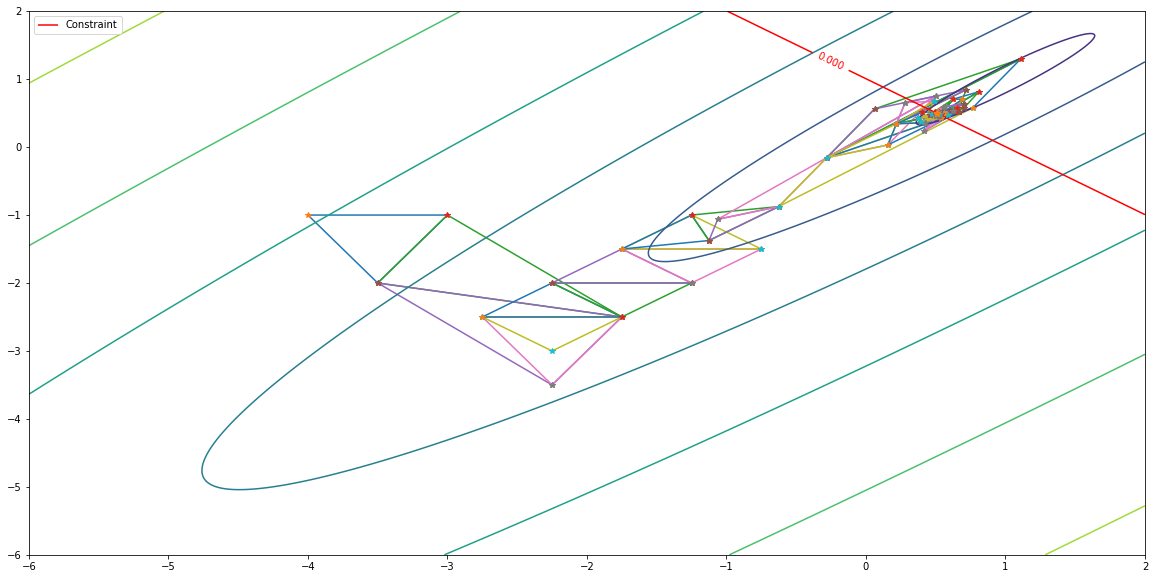

In [160]:
%matplotlib inline
X_0 = [(-3,-1),(-4,-1),(-3.5,-2)]
optimal,n_iter, history = Nelder_Mead_opt(f,f_constraint,X_0,n=3,eps=eps,alpha=1,beta=0.5,gamma=2,delta=0.5,print_flag=True,plot_flag=True, max_iter=100)

In [166]:
optimal[0]

array([0.51133713, 0.48741524, 0.70319523])

In [167]:
n_iter

In [168]:
print(history)

[[(-3.5, -2.0), (-3.0, -1.0), (-4.0, -1.0)], [(-1.75, -2.5), (-3.5, -2.0), (-3.0, -1.0)], [(-1.75, -2.5), (-2.25, -3.5), (-3.5, -2.0)], [(-1.75, -2.5), (-2.75, -2.5), (-2.25, -3.5)], [(-1.75, -2.5), (-2.75, -2.5), (-2.25, -3.0)], [(-2.25, -2.0), (-1.75, -2.5), (-2.75, -2.5)], [(-1.25, -2.0), (-2.25, -2.0), (-1.75, -2.5)], [(-1.75, -1.5), (-1.25, -2.0), (-2.25, -2.0)], [(-1.75, -1.5), (-0.75, -1.5), (-1.25, -2.0)], [(-1.25, -1.0), (-1.75, -1.5), (-0.75, -1.5)], [(-1.125, -1.375), (-1.25, -1.0), (-1.75, -1.5)], [(-0.625, -0.875), (-1.125, -1.375), (-1.25, -1.0)], [(-0.625, -0.875), (-1.0625, -1.0625), (-1.125, -1.375)], [(-0.28125, -0.15625), (-0.625, -0.875), (-1.0625, -1.0625)], [(0.765625, 0.578125), (-0.28125, -0.15625), (-0.625, -0.875)], [(1.109375, 1.296875), (-0.28125, -0.15625), (0.765625, 0.578125)], [(-0.28125, -0.15625), (0.0625, 0.5625), (1.109375, 1.296875)], [(0.5, 0.75), (-0.28125, -0.15625), (0.0625, 0.5625)], [(0.15625, 0.03125), (-0.28125, -0.15625), (0.5, 0.75)], [(0.

In [169]:
f_constraint(5.11337131e-01, 4.87415238e-01)

True